# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = y_train.max() - y_train.min() +1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

The following cell shows 20 images picked from the training set.

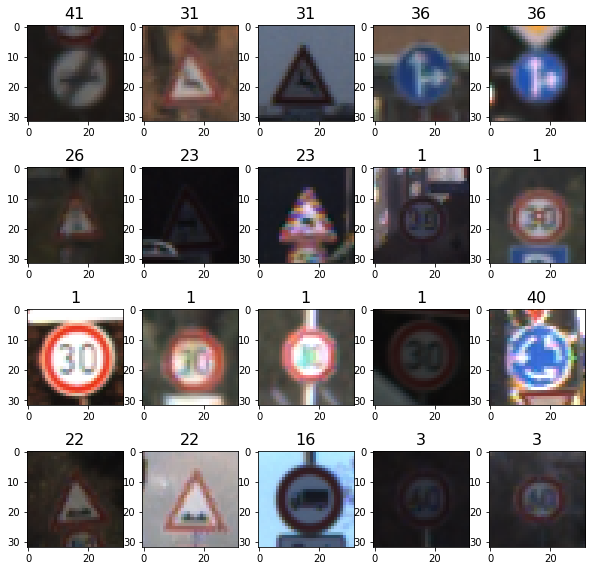

In [3]:

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

row = 4
colum = 5
fig = plt.figure(figsize = (10,10))
for i in range (row * colum):
    image_idx = i * 300
    ax = fig.add_subplot(row, colum, i+1)
    ax.set_title("{}".format(y_train[image_idx]),fontsize = 16)
    ax.imshow(X_train[image_idx])

The following cell shows a histogram of data distribution across the training set.

Text(0,0.5,'distribution')

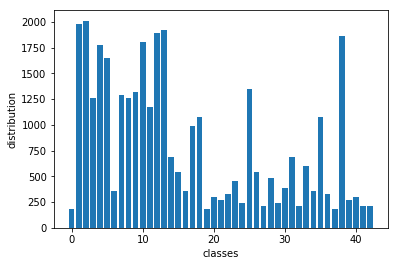

In [4]:
# plot a histogram on training data distribution
import numpy as np

distribution = [0]*n_classes
for label in y_train:
    distribution[label] +=1

classes = list(range(0,43))
plt.bar(classes,distribution,align='center') # A bar chart
plt.xlabel('classes')
plt.ylabel('distribution')

----

## Step 2: Design and Test a Model Architecture



### Pre-process the Data Set (normalization, grayscale, etc.)

Two basic data processings are used:(1) normalization, which converts each image pixel to value between [0,1] (2)image rotation: each image is rotated either [1,15] degree or [-1,-15] degree, the rotation direction is chosen randomly, the rotation angle is also chosen randomly. The implementation below only enables [1,15] option, PIL rotation function gives some unpredicted result when rotation angle > 180 degree.

The reason to use normalization is to convert data set into a fix range, so weights after training won't have huge magnitude difference. The reason to rotate images is to introduce more randomness to the training set so the network won't 'remember' a particular data pattern.

In [5]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from PIL import Image

def normalize (X):
     return (X - 128.0)/128.0

def rotate (X):
    # randomly rotate an image counter clockwise 1-15 degree
    img = Image.fromarray(X.astype('uint8'))
    if np.random.choice([1,1]):
        angle = np.random.choice(np.random.randint(1,15))
    else:
        angle = np.random.choice(np.random.randint(345,359))
    rot_image = img.rotate(angle,resample=Image.BICUBIC, expand=False)
    return np.array(rot_image)

def img_process (X):
    # first rotate the original image, then normalize it
    rot_img = rotate(X)
    norm_img = normalize(rot_img)
    return norm_img

#### Image Rotation and Normalization

The cell visulize the images after the processing. The small rotation on some images can be seen.

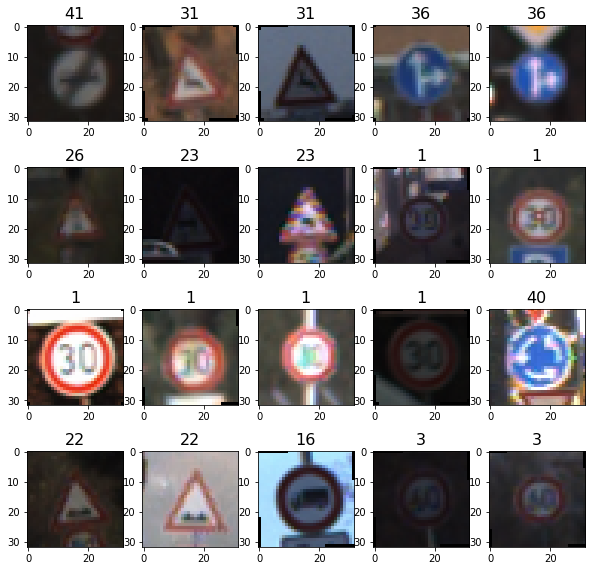

In [6]:
# process each training set image
X_train_new = []
for i in range(len(X_train)):
    X_train_new.append(img_process(X_train[i]))

row = 4
colum = 5
fig = plt.figure(figsize = (10,10))
for i in range (row * colum):
    image_idx = i * 300
    ax = fig.add_subplot(row, colum, i+1)
    ax.set_title("{}".format(y_train[image_idx]),fontsize = 16)
    ax.imshow((X_train_new[image_idx]/2.0+0.5))

For validation set and test set, only normalization is applied.

In [7]:
#for validation set and test set, only apply normalization
X_valid_new = []
X_test_new = []
for i in range(len(X_valid)):
    X_valid_new.append(normalize(X_valid[i]))
    
for i in range(len(X_test)):
    X_test_new.append(normalize(X_test[i]))


### Model Architecture

LeNet is used as the traffic sign classifier, the CNN defined below has 7 layers in total ( 3 convolutional layers + 4 fully connected layers). Size of the layers are : layer1 = 32x32x3, layer2=15x15x32, layer3 = 6x6x64, layer4 = 512x1, layer5 = 800x1, layer6 = 400x1, layer7 = 43x1.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3,3,3,32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1   = tf.nn.relu(conv1)
    # pooling : input 30,30,32, output = 15,15,32
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. input = 15x15x32, Output = 13x13x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3,3,32,64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2   = tf.nn.relu(conv2)
    # Pooling. Input = 13x13x64. Output = 6x6x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Conv layer 3: input = 6x6x64, output = 4x4x128
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(128))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3   = tf.nn.relu(conv3)
    # Pooling. Input = 4,4,128. Output = 2x2x128.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Flatten. Input = 2x2x128. Output = 512.
    fc0   = flatten(conv3)
    
    # SOLUTION: FC1: Input = 512. Output = 800.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(512, 800), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(800))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)
    
    # SOLUTION: FC2: Input = 800. Output = 400.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(800,400),mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(400))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: FC2: Input = 400. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(400,43),mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits



### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Draw Tensorflow Graph

In [9]:
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#### Model Evaluation

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train the Model

The model is trained using Adam optimizer, batch size = 128 and number of epochs is increased to 15 to improve the model performance.

In [11]:
from sklearn.utils import shuffle

EPOCHS = 15
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_new)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_new, y_train = shuffle(X_train_new, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_new[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_new, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.768

EPOCH 2 ...
Validation Accuracy = 0.880

EPOCH 3 ...
Validation Accuracy = 0.894

EPOCH 4 ...
Validation Accuracy = 0.889

EPOCH 5 ...
Validation Accuracy = 0.870

EPOCH 6 ...
Validation Accuracy = 0.899

EPOCH 7 ...
Validation Accuracy = 0.895

EPOCH 8 ...
Validation Accuracy = 0.912

EPOCH 9 ...
Validation Accuracy = 0.900

EPOCH 10 ...
Validation Accuracy = 0.925

EPOCH 11 ...
Validation Accuracy = 0.928

EPOCH 12 ...
Validation Accuracy = 0.926

EPOCH 13 ...
Validation Accuracy = 0.922

EPOCH 14 ...
Validation Accuracy = 0.933

EPOCH 15 ...
Validation Accuracy = 0.940

Model saved


#### Test the Classification Performance on Test Set

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    validation_accuracy = evaluate(X_test_new, y_test)
    print("Test Accuracy = {:.3f}".format(validation_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.930


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

First the GTSRB data set is converted from .ppm file to .jpg file.

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#change image type from ppm to jpg
img_ppm = ['Class_15.ppm','Class_18.ppm','Class_30.ppm','Class_38.ppm','Class_6.ppm','Class_9.ppm']
folder_dir = 'GTSRB/'
img_jpg = ['Class_15.jpg','Class_18.jpg','Class_30.jpg','Class_38.jpg','Class_6.jpg','Class_9.jpg']
for i in range(6):
    img = Image.open(folder_dir+img_ppm[i])
    img.save(folder_dir+img_jpg[i])

Second, the images are preprocessed which mainly includes two steps: (1) make all images 32x32 by size (2)normalize each image as before. The GTSRB data set has images of size from 15x15 to 250x250 and contains rectangular images, therefore, there are three steps to resize the images: (1)check the shape of image, if the image is rectangular, padding the image to make is square; (2) if the square image is < 32x32, padding the image to >=32x32; (3)thumbnail the square image into 32x32, in which way the ratio of image is kept.

In [21]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from PIL import Image
import numpy as np

# resize image to 32x32 and normalize image
def preprocess (img_path):
    img = Image.open(img_path)
    img = np.array(img)
    h,w,_ = img.shape
    #print("Original Image Size:",img.shape)
    # make all images square
    if h > w:
        pad_1 = int(np.ceil((h-w)/2.0))
        pad_2 = int(np.floor((h-w)/2.0))
        img_squ = np.pad(img,((0,0),(pad_1,pad_2),(0,0)),'constant')
    elif h < w:
        pad_1 = int(np.ceil((w-h)/2.0))
        pad_2 = int(np.floor((w-h)/2.0))
        img_squ = np.pad(img,((pad_1,pad_2),(0,0),(0,0)),'constant')
    else:
        img_squ = img
        
    # make all images >= 32x32
    h,w,_ = img_squ.shape
    if h < 32:
        pad = int(np.ceil((32-h)/2.0))
        img_aug = np.pad(img_squ,((pad,pad),(pad,pad),(0,0)),'constant')
    else:
        img_aug = img_squ
    
    # create thumbnail of images with size exactly 32x32
    img_thumb = Image.fromarray(img_aug)
    img_thumb.thumbnail([32,32],Image.ANTIALIAS)
    
    #normalize the image
    img_nor = normalize(np.array(img_thumb))
    
    return img_nor

Visulize the images with their label, the images chosen from GTSRB are kind of hard to see by human eyes, but this is the opportunity to check what CNN can do. The size of original image is also printed to double check the proprocessing result.

Original Image Size: (50, 49, 3)
Original Image Size: (29, 30, 3)
Original Image Size: (40, 47, 3)
Original Image Size: (37, 36, 3)
Original Image Size: (30, 30, 3)
Original Image Size: (42, 43, 3)


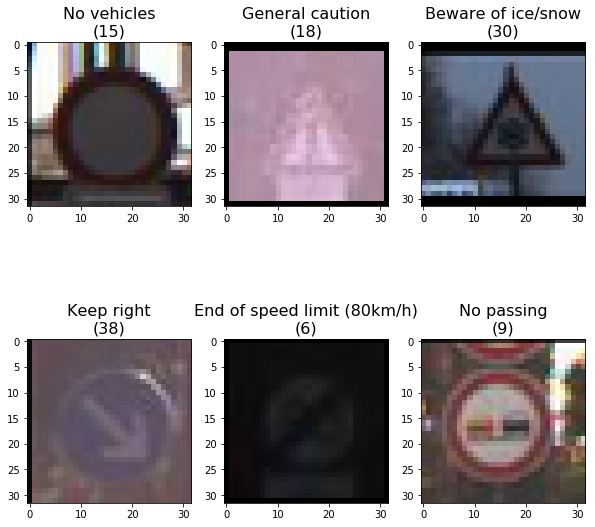

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Read sign names from csv using pandas
sign_names = pd.read_csv("./signnames.csv")
name_dict = pd.Series(sign_names.SignName, index=sign_names.ClassId)
sign_label = [15,18,30,38,6,9]

# show the 6 GTSRB images
fig = plt.figure(figsize=(10,10))
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.set_title("{}\n({})".format(name_dict[sign_label[i]],sign_label[i]), fontsize=16)    
    img = preprocess(folder_dir+img_jpg[i])
    ax.imshow(img/2.0+0.5)

### Predict the Sign Type for Each Image

In [18]:
# load the weights and run the model
import tensorflow as tf

sess = tf.Session()
saver.restore(sess, tf.train.latest_checkpoint('.'))

def predict_sign(image):
    batch_x, batch_y = np.expand_dims(image, axis=0), np.zeros((1,n_classes))
    logits_vals = sess.run(logits, feed_dict={x: batch_x, y: batch_y})
    return logits_vals

INFO:tensorflow:Restoring parameters from ./lenet


The logits for each image is obtained, using .argmax() function, indice of the prediction can be found, which is the label. The correct label and predicted label are both shown for comparison.

Original Image Size: (50, 49, 3)
Original Image Size: (29, 30, 3)
Original Image Size: (40, 47, 3)
Original Image Size: (37, 36, 3)
Original Image Size: (30, 30, 3)
Original Image Size: (42, 43, 3)


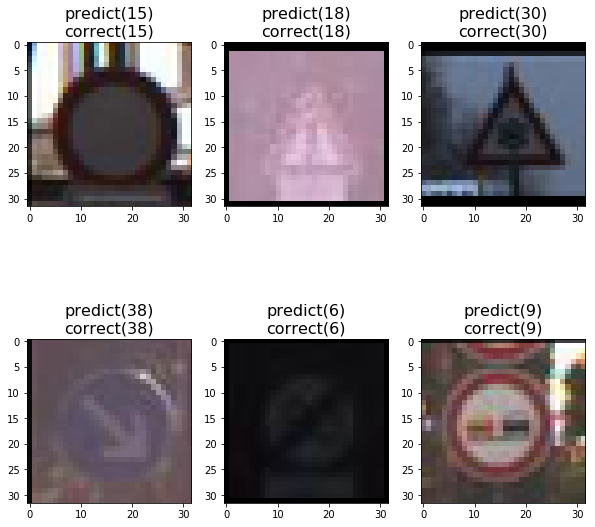

In [20]:
fig = plt.figure(figsize=(10,10))
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    img = preprocess(folder_dir+img_jpg[i])
    logits_value = predict_sign(img)
    sign = logits_value.argmax()
    ax.set_title("predict({})\ncorrect({})".format(sign,sign_label[i]), fontsize=16)    
    ax.imshow(img/2.0+0.5)

### Analyze Performance

In [23]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
accuracy=0.0
for i in range(6):
    img = preprocess(folder_dir+img_jpg[i])
    logits_value = predict_sign(img)
    sign = logits_value.argmax()
    if sign == sign_label[i]:
        accuracy +=1
accuracy = accuracy/6.0
print ("accuracy is:",accuracy)

accuracy is: 1.0


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

The top 5 predictions of the CNN are shown, it can be seen that the classifier does a pretty good job by predicting a label with almost 100% confidence.

In [26]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
for i in range(6):
    img = preprocess(folder_dir+img_jpg[i])
    logits_value = predict_sign(img)
    softmax_top5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits_value), k=5))
    print("top 5 predictions for sign ({}) are\n".format(sign_label[i]),softmax_top5)
    print("\n")

top 5 predictions for sign (15) are
 TopKV2(values=array([[  1.00000000e+00,   5.39594980e-10,   3.29274975e-11,
          3.76289339e-14,   2.49058603e-14]], dtype=float32), indices=array([[15,  9, 26,  8, 22]], dtype=int32))


top 5 predictions for sign (18) are
 TopKV2(values=array([[  9.98297632e-01,   7.42512639e-04,   7.26589700e-04,
          8.01400674e-05,   7.63755088e-05]], dtype=float32), indices=array([[18, 38, 25, 41,  0]], dtype=int32))


top 5 predictions for sign (30) are
 TopKV2(values=array([[  1.00000000e+00,   2.09865867e-08,   7.16761672e-09,
          4.08540091e-10,   3.59840796e-10]], dtype=float32), indices=array([[30, 11, 23, 24, 41]], dtype=int32))


top 5 predictions for sign (38) are
 TopKV2(values=array([[  9.99999881e-01,   8.59474838e-08,   3.05817949e-09,
          2.98315750e-09,   1.64043867e-09]], dtype=float32), indices=array([[38, 36,  2, 13, 34]], dtype=int32))


top 5 predictions for sign (6) are
 TopKV2(values=array([[ 0.9138881 ,  0.06532597, 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")